# Minimal-working example for RetinaFace

Objectives:
-   try [RetinaFace][RetinaFace] (as a [PyPI package][RetinaFace-pypi]) to detect faces,
-   try another repository with both RetinaFace and [DSFD][DSFD],
-   (manually) compare detection results to [my previous results][previous_results]

[RetinaFace]: <https://github.com/ternaus/retinaface>
[RetinaFace-pypi]: <https://pypi.org/project/retinaface-pytorch/>
[DSFD]: <https://github.com/hukkelas/DSFD-Pytorch-Inference>
[previous_results]: <https://github.com/woctezuma/steam-face-detection#results>

## Data

In [1]:
app_ids = ['1271300', '1323710', '554180', '1449370']
base_url = 'https://cdn.cloudflare.steamstatic.com/steam/apps/'

for i, app_id in enumerate(app_ids, start=1):
  fname = 't{}.jpg'.format(i)
  !curl -o {fname} {base_url}{app_id}/library_600x900.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  103k  100  103k    0     0   675k      0 --:--:-- --:--:-- --:--:--  675k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79836  100 79836    0     0   206k      0 --:--:-- --:--:-- --:--:--  205k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77608  100 77608    0     0   206k      0 --:--:-- --:--:-- --:--:--  206k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 71944  100 71944    0     0   390k      0 --:--:-- --:--:-- --:--:--  390k


## Boilerplate functions

In [2]:
import cv2
from google.colab.patches import cv2_imshow

def show_detected_faces(image_bgr, annotation, output_filename = None):
  blue_color = (255, 0, 0)
  green_color = (0, 255, 0)
  red_color = (0, 0, 255)

  for i in range(len(annotation)):
      try:
        box = annotation[i]['bbox']
      except (IndexError, KeyError):
        box = annotation[i, :]
      
      cv2.rectangle(image_bgr, (box[0], box[1]), (box[2], box[3]), red_color, 2)

      try:
        landmark5 = annotation[i]['landmarks']
      except (IndexError, KeyError):
        landmark5 = []
      
      for l in range(len(landmark5)):
          if l == 0 or l == 3:
            color = green_color
          else:
            color = blue_color
          cv2.circle(image_bgr, (landmark5[l][0], landmark5[l][1]), 1, color, 2)

  cv2_imshow(image_bgr)

  if output_filename is not None:
    cv2.imwrite(output_filename, image_bgr)

## RetinaFace

This relies on [RetinaFace][RetinaFace], provided as a [PyPI package][RetinaFace-pypi] using PyTorch.

[RetinaFace]: <https://github.com/ternaus/retinaface>
[RetinaFace-pypi]: <https://pypi.org/project/retinaface-pytorch/>

### Requirements

In [3]:
%pip install retinaface_pytorch

     |████████████████████████████████| 7.4MB 10.7MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 112kB 51.5MB/s 
     |████████████████████████████████| 163kB 54.2MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 4.5MB 57.6MB/s 
     |████████████████████████████████| 2.1MB 58.6MB/s 
     |████████████████████████████████| 634kB 53.5MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
     |████████████████████████████████| 122kB 54.0MB/s 
  Created wheel for blinker: filename=blinker-1.4-cp36-none-any.whl size=13450 sha256=a1627c10beac2e6a21e63ad03c1fb6f9b279d2e00d18ac2833a165a20233022f
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
  Created wheel for watchdog: filename=watchdog-0.10.4-cp36-none-any.whl size=74841 sha256=188fb56112a7cfbc4132b9413b0cfecff89fc313f701b87e67f9c676ea4823fb
  Stored in directory: /root

### Run

/usr/local/lib/python3.6/dist-packages/torch/hub.py:483: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


Detection time: 0.097 s
#faces = 63
Scores: [0.995, 0.995, 0.994, 0.991, 0.99, 0.99, 0.989, 0.987, 0.987, 0.986, 0.985, 0.985, 0.982, 0.982, 0.981, 0.981, 0.98, 0.978, 0.978, 0.978, 0.977, 0.976, 0.974, 0.974, 0.974, 0.971, 0.971, 0.97, 0.97, 0.969, 0.969, 0.963, 0.963, 0.962, 0.956, 0.952, 0.949, 0.947, 0.942, 0.926, 0.926, 0.914, 0.899, 0.88, 0.88, 0.873, 0.87, 0.86, 0.754, 0.709, 0.692, 0.668, 0.507, 0.322, 0.296, 0.293, 0.218, 0.212, 0.181, 0.163, 0.139, 0.139, 0.098]


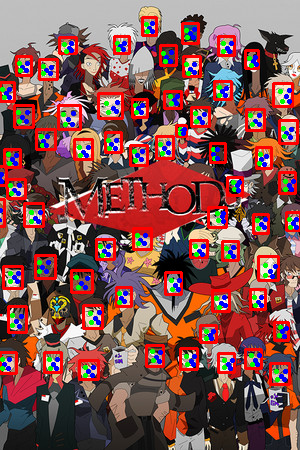

In [43]:
import time
import cv2
from retinaface.pre_trained_models import get_model

img_no = 1

confidence_threshold = 0.08 # an important parameter for hard cases
nms_threshold = 0.01

max_size = 840 # a very important parameter (do not change if unsure)
#
# - cf. section 4.2 in the article, which suggests a value of 640:
# "RetinaFace: Single-shot Multi-level Face Localisation in the Wild"
#
# - cf. config which suggests a value of 840:
# https://github.com/ternaus/retinaface/issues/26

model = get_model("resnet50_2020-07-20",
                  max_size=max_size,
                  device='cuda')
model.eval()

fname = 't{}.jpg'.format(img_no)
image_bgr = cv2.imread(fname) # BGR
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # RGB

t = time.time()
annotation = model.predict_jsons(image_rgb,
                                 confidence_threshold=confidence_threshold,
                                 nms_threshold=nms_threshold)
print(f"Detection time: {time.time()- t:.3f} s")

scores = [
          float('{:.3f}'.format(f['score']))
          for f in annotation
          ]

print('#faces = {}'.format(len(annotation)))
print('Scores: {}'.format(scores))

annotation[0]

show_detected_faces(image_bgr,
                    annotation,
                    output_filename='temp.jpg')

## DSFD or RetinaFace

This relies on [DSFD][DSFD].

[DSFD]: <https://github.com/hukkelas/DSFD-Pytorch-Inference>

### Requirements

In [5]:
%pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git

  Cloning https://github.com/hukkelas/DSFD-Pytorch-Inference.git to /tmp/pip-req-build-26ta4rjp
  Running command git clone -q https://github.com/hukkelas/DSFD-Pytorch-Inference.git /tmp/pip-req-build-26ta4rjp
  Created wheel for face-detection: filename=face_detection-0.2.1-cp36-none-any.whl size=29723 sha256=3abc28e660946f076c207dac3c2c80f0240271e8db904116c76c24e9016dca7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ykxcieni/wheels/25/46/90/b08e1f7237d1e592551ee0ca37accce78ca2271f91a930c973
Successfully built face-detection


### Run

['DSFDDetector', 'RetinaNetResNet50', 'RetinaNetMobileNetV1']
Detection time: 0.128 s
#faces = 67
Scores: [0.997, 0.997, 0.997, 0.995, 0.994, 0.993, 0.992, 0.991, 0.991, 0.991, 0.991, 0.99, 0.99, 0.989, 0.989, 0.985, 0.983, 0.983, 0.981, 0.979, 0.979, 0.973, 0.97, 0.966, 0.963, 0.96, 0.96, 0.96, 0.959, 0.958, 0.956, 0.956, 0.955, 0.954, 0.948, 0.945, 0.938, 0.936, 0.936, 0.934, 0.934, 0.925, 0.918, 0.908, 0.908, 0.906, 0.83, 0.822, 0.816, 0.801, 0.801, 0.78, 0.763, 0.672, 0.626, 0.545, 0.468, 0.433, 0.382, 0.266, 0.223, 0.173, 0.168, 0.149, 0.145, 0.135, 0.091]


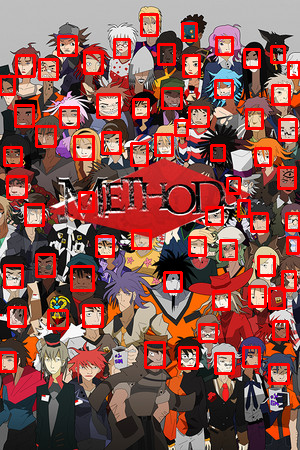

In [42]:
import face_detection

img_no = 1

print(face_detection.available_detectors)

model_name = 'DSFDDetector' 
# model_name = 'RetinaNetResNet50'
# model_name = 'RetinaNetMobileNetV1'

confidence_threshold = 0.08
nms_threshold = 0.01
max_size = 840

fname = 't{}.jpg'.format(img_no)
image_bgr = cv2.imread(fname) # BGR
image_rgb = image_bgr[:, :, ::-1] # RGB

detector = face_detection.build_detector(name=model_name, 
                                         confidence_threshold=confidence_threshold, 
                                         nms_iou_threshold=nms_threshold,
                                         max_resolution=max_size)

t = time.time()
detections = detector.detect(image_rgb)
print(f"Detection time: {time.time()- t:.3f} s")

scores = [
          float('{:.3f}'.format(f[-1]))
          for f in detections
          ]

print('#faces = {}'.format(len(detections)))
print('Scores: {}'.format(scores))

show_detected_faces(image_bgr, 
                    detections, 
                    'temp.jpg')

Done.